<a href="https://colab.research.google.com/github/Wezz-git/AI-samples/blob/main/(XAI)_(SHAP)_Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Business Problem:

You're back at the telecom company. You presented your 82% accurate churn model (from Day 1) to your boss. She says, "This is great. But I can't just block a customer's account or offer them a discount because 'the model said so.' I need to know why. Is it because their bill is high? Is it because they have a month-to-month contract? If you can't tell me why, I can't use this."



This is Explainable AI (XAI). In regulated industries like banking and finance, it's not just a "nice-to-have"—it's often a legal requirement. You must be able to explain why your model denied someone a loan or flagged them for fraud.

Tool: SHAP (SHapley Additive exPlanations). This is the industry-standard library for creating charts that show exactly which features (columns) had the biggest impact on a model's prediction.

In [5]:
import pandas as pd

file_name = '/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(file_name)
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [6]:
convert_totalCharges_to_numeric = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Step 1 - Convert the column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Step 2 - Find out how many NaN you created
# .isnull() returns True/False for each row
# .sum() counts all the 'True' values

nan_count = df['TotalCharges'].isnull().sum()
print(f"found{nan_count} missing 'TotalCharges' values.")

# Step 3 - Fill those NaNs with 0.0
# WE use inplace=True to midfy the DataFrame directly
df['TotalCharges'].fillna(0.0, inplace=True)
print("Filled missing numbers with 0.0")

# Step 4 - check the work
print("\n-- updated data summary--")
df.info()

found11 missing 'TotalCharges' values.
Filled missing numbers with 0.0

-- updated data summary--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   obje

/tmp/ipython-input-3159993191.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0.0, inplace=True)


In [10]:
df_cleaned = df.drop('customerID', axis=1)

#Now, the function (pd.get_dummies())will be added

df.processed = pd.get_dummies(df_cleaned)

print("-- processed data (top 5 rows) --")
print(df.processed.head())

print("n\-- new data summary --")
print(df.processed.info())

-- processed data (top 5 rows) --
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Female  \
0              0       1           29.85         29.85           True   
1              0      34           56.95       1889.50          False   
2              0       2           53.85        108.15          False   
3              0      45           42.30       1840.75          False   
4              0       2           70.70        151.65           True   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0        False       False         True           True           False  ...   
1         True        True        False           True           False  ...   
2         True        True        False           True           False  ...   
3         True        True        False           True           False  ...   
4        False        True        False           True           False  ...   

   Contract_One year  Contract_Two year  PaperlessBi

<>:10: SyntaxWarning: invalid escape sequence '\-'
<>:10: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipython-input-72702113.py:10: SyntaxWarning: invalid escape sequence '\-'
  print("n\-- new data summary --")


In [11]:
# 1 - Create your 'y' (the target)
# Just select the 'Churn_Yes' column

y = df.processed['Churn_Yes']

# 2 - Create your 'X' (the features)
# Drop the two 'Churn' Columns to get everything else
X = df.processed.drop(['Churn_Yes', 'Churn_No'], axis=1)

print(" -- Features (X) --")
print(X.head())

print("\n -- Target (y) --")
print(y.head ())

 -- Features (X) --
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Female  \
0              0       1           29.85         29.85           True   
1              0      34           56.95       1889.50          False   
2              0       2           53.85        108.15          False   
3              0      45           42.30       1840.75          False   
4              0       2           70.70        151.65           True   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0        False       False         True           True           False  ...   
1         True        True        False           True           False  ...   
2         True        True        False           True           False  ...   
3         True        True        False           True           False  ...   
4        False        True        False           True           False  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year

Logistic Reg -

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2 - use the 'y' and 'X' from last time
y = df.processed['Churn_Yes']
X = df.processed.drop(['Churn_Yes', 'Churn_No'], axis=1)

# 3 - Convert True/False to 1/0
y = y.astype(int)
X = X.astype(int)

print(" -- Features (X) --")
print(X.head())

print("\n -- Target (y) --")
print(y.head ())

# 4 - split the data
# save 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5 - create the model. with a simple, classic model
# Max_iter=1000 allows it to run
model = LogisticRegression(max_iter=1000)

# 6 - train the model
model.fit(X_train, y_train)
print("training complete")

# 7 - make prediction on the test model
predictions = model.predict(X_test)

# 8 - Score the model
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

 -- Features (X) --
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Female  \
0              0       1              29            29              1   
1              0      34              56          1889              0   
2              0       2              53           108              0   
3              0      45              42          1840              0   
4              0       2              70           151              1   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0            0           0            1              1               0  ...   
1            1           1            0              1               0  ...   
2            1           1            0              1               0  ...   
3            1           1            0              1               0  ...   
4            0           1            0              1               0  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGBClassifier -

In [12]:
# 1 - import new tools
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 2 - Need to get a few from the previous cell
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Redefine X and y to ensure they are available
y = df.processed['Churn_Yes']
X = df.processed.drop(['Churn_Yes', 'Churn_No'], axis=1)

# Convert True/False to 1/0
y = y.astype(int)
X = X.astype(int)

# 3 - Split the data - same as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4 - Create the Advanced model
# XGBoost model will be used
pro_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 5 - Train the Advanced model
print("training the advanced model")
pro_model.fit(X_train, y_train)
print("training complete")

# 6 -  make the predictions
pro_predictions = pro_model.predict(X_test)

# 7 - Score the Advanced model
accuracy = accuracy_score(y_test, pro_predictions)
print(f"Advanced Model Accuracy: {accuracy * 100:.2f}%")

print("\n --Classification report --")

print(classification_report(y_test, pro_predictions, target_names=['Did Not Churn (0)', 'Churned (1)']))

training the advanced model
training complete
Advanced Model Accuracy: 78.64%

 --Classification report --
                   precision    recall  f1-score   support

Did Not Churn (0)       0.83      0.89      0.86      1036
      Churned (1)       0.62      0.50      0.55       373

         accuracy                           0.79      1409
        macro avg       0.73      0.69      0.71      1409
     weighted avg       0.78      0.79      0.78      1409



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:56:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Heres where the continuation of day 1 starts: SHAP Explainer

In [14]:
!pip install shap

In [15]:
import shap

# 1 - create the explainer
# tell SHAP to use a 'TreeExplainer' because XGBoost is a tree-based model

shap_explainer = shap.TreeExplainer(pro_model)

# 2 - Calculate SHAP values
# SHAP runs a bunch of simulations to see how each feature affect the mdoels output on the training data.

print("Calculating SHAP values... (This may take a minute)")

shap_values = shap_explainer.shap_values(X_test)

print("SHAP values calculated!")

Calculating SHAP values... (This may take a minute)
SHAP values calculated!


Create the most important plot in XAI:

The Global Feature Importance plot.

-- SHAP Global Feature Importance --


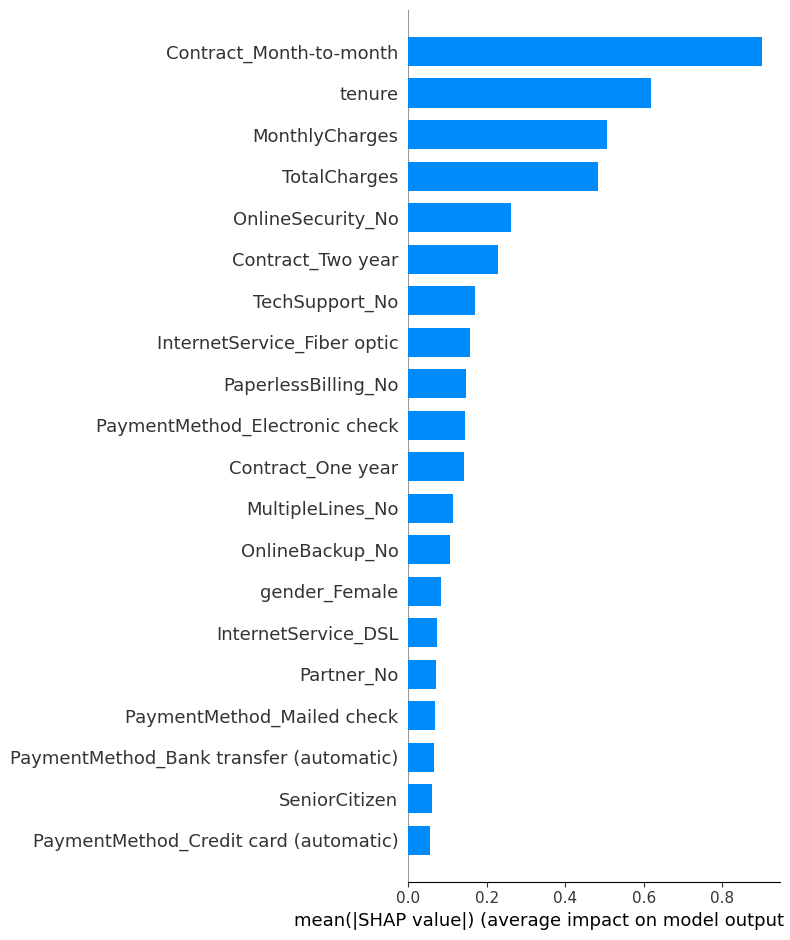

In [16]:
import matplotlib.pyplot as plt

# 1 - create summary plot
# Global timportance chart

print("-- SHAP Global Feature Importance --")
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",      # A simple bar chart
    show=False            # Show it manually
    )

plt.show()

The model is 78.64% accurate, and it's making its decisions primarily by looking at the customer's contract type, tenure, and monthly charges.